<a href="https://colab.research.google.com/github/Talha-Bicak/Predicting_Tesla_stocks/blob/main/predict_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/TSLA.csv'

In [ ]:
df = pd.read_csv(dir_path)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
# Veri seti hakkında bilgilerin tespit edilmesi
def check_df(dataframe, head=5):
  print("##################### Shape #############")
  print(dataframe.shape)
  print("##################### Types #####################")
  print(dataframe.dtypes)
  print("##################### Head #####################")
  print(dataframe.head(head))
  print("##################### Tail #####################")
  print(dataframe.tail(head))
  print("##################### NA #####################")
  print(dataframe.isnull().sum())
  print("##################### Quantiles #####################")
  print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

##################### Shape #############
(2416, 7)
##################### Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
##################### Head #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
##################### Tail #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002 

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [ ]:
tesla_df = df[["Date","Close"]]

In [ ]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [ ]:
print("Minimum Tarih: ", tesla_df["Date"].min())
print("Maksimum Tarih: ", tesla_df["Date"].max())

Minimum Tarih:  2010-06-29 00:00:00
Maksimum Tarih:  2020-02-03 00:00:00


In [ ]:
tesla_df.index = tesla_df['Date']

In [ ]:
tesla_df.head()

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001


In [ ]:
tesla_df.drop('Date', axis = 1, inplace= True)

In [ ]:
tesla_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [ ]:
result_df = tesla_df.copy()

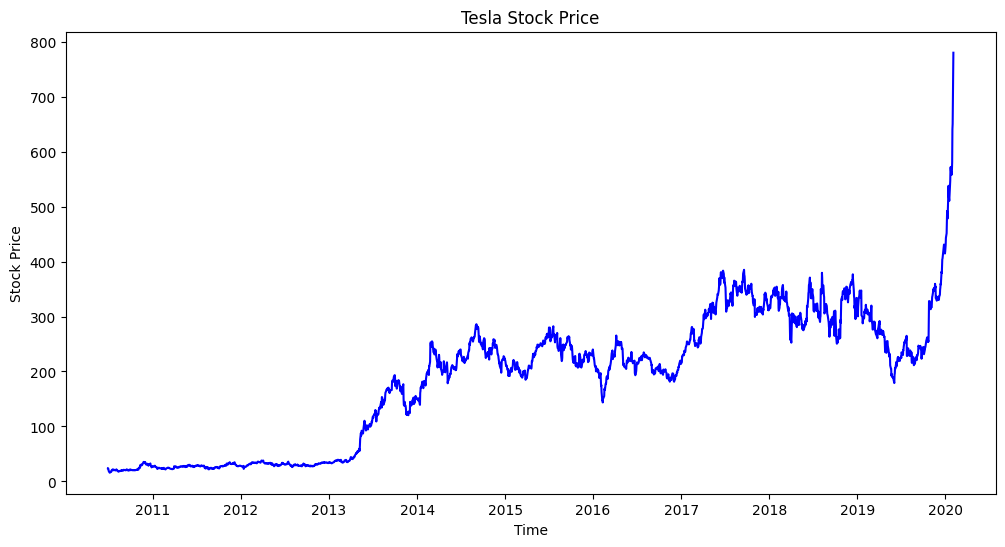

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df['Close'], color ='blue');
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price')
plt.xlabel('Time')
plt.show()

In [ ]:
tesla_df = tesla_df.values #Numpy Dizisine çevirme

In [ ]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [ ]:
tesla_df = tesla_df.astype('float32')

In [ ]:
# Üzerinde çalıştığımız veri seti bir zaman serisi olduğundan ötürü kontrollü bir biçimde ayırma işlemini yapmamız gerekiyor.
def split_data(dataframe , test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train , test, position


In [ ]:
train, test, position = split_data(tesla_df, 0.20)

In [ ]:
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [ ]:
sc_train = MinMaxScaler(feature_range = (0,1))
train = sc_train.fit_transform(train)

In [ ]:
sc_test = MinMaxScaler(feature_range = (0,1))
test = sc_test.fit_transform(test)

In [ ]:
test[:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [ ]:
#Bir önceki adıma gidip işlemler yapılması için kullanılacak olan fonksiyon
def create_features(data, lookback):
  X, Y = [] , []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X) , np.array(Y)

In [ ]:
lookback = 20

In [ ]:
#Train Veri Seti
X_train , y_train =create_features(train, lookback)

In [ ]:
# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [ ]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [ ]:
# Veri setini istenilen formata getirme
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape) #Boyut arttırma işlemi uygulanmış

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50,activation='relu',input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode =  "min"),
            ModelCheckpoint(filepath = 'mymodel.h5', monitor = 'val_loss', mode = 'min', save_best_only= True, save_weights_only=False)]

In [ ]:
history = model.fit(X_train, y_train, epochs= 100, batch_size=20, validation_data = (X_test, y_test), callbacks = callbacks, shuffle = False)

Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 6/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 7/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 8/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 9/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 10/100
96/96 [==============================] - 1s 6ms/step - loss: 0.0039 - val_loss: 0.0025
Epoc

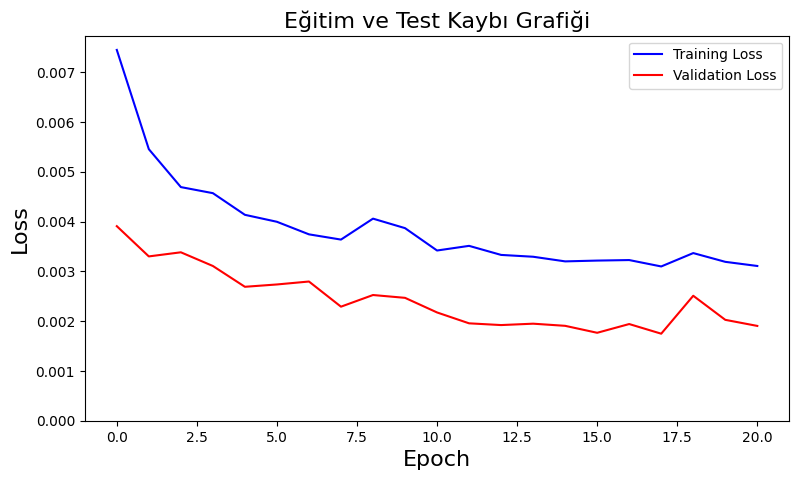

In [ ]:

plt.figure(figsize= (20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize= 16)
plt.ylabel('Loss', fontsize= 16)
plt.ylim([0,max(plt.ylim())])
plt.title('Eğitim ve Test Kaybı Grafiği', fontsize=16)
plt.show()

In [ ]:
loss = model.evaluate(X_test, y_test, batch_size = 1)
print("\nTest Loss: %1.f%%" % (100.0 * loss))

463/463 [==============================] - 1s 2ms/step - loss: 0.0019

Test Loss: 0%


In [ ]:
train_predict = model.predict(X_train)


60/60 [==============================] - 0s 3ms/step


In [ ]:
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [ ]:
train_predict = sc_train.inverse_transform(train_predict)
test_predict = sc_test.inverse_transform(test_predict)

In [ ]:
y_train = sc_train.inverse_transform(y_train)
y_test = sc_test.inverse_transform(y_test)

In [ ]:
# Train veri setine ait Root Mean Squared Error değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [ ]:
# Test veri setine ait Root Mean Squared Error değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:
print(f"Train Veri Setine Ait RMSE Değeri: {train_rmse}")
print(f"Test Veri Setine Ait RMSE Değeri: {test_rmse}")

Train Veri Setine Ait RMSE Değeri: 13.426337242126465
Test Veri Setine Ait RMSE Değeri: 26.227325439453125


In [ ]:
train_prediction_df = result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,32.125511
2010-07-29,20.350000,32.113419
2010-07-30,19.940001,32.180813
2010-08-02,20.920000,32.262218
2010-08-03,21.950001,32.295757
